# Implementation of CoFi for marine traffic modeling

This notebook showcases how to use Consititional Filters (CoFi) in ProMis to improve modeling of ship movements.

## Setup

In [1]:
# This will auto-relead changed ProMis imports
%reload_ext autoreload
%autoreload 2

In [2]:
# We need some additional packages
!pip install -q svgpath2mpl svgpathtools filterpy keplergl

In [3]:
# Standard library
import json
from copy import copy
from math import ceil, isfinite
from pathlib import Path
from time import monotonic
from warnings import filterwarnings

# Math
import numpy as np
from numpy import array, deg2rad, eye, mean, ndarray, pi, set_printoptions, stack
from numpy.random import seed, standard_normal
from scipy.stats import norm, uniform

# Data Handling
import pandas as pd
from filterpy.monte_carlo import systematic_resample

# Plotting
import matplotlib
from keplergl import KeplerGl
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib.transforms import Affine2D
from seaborn import move_legend
from svgpath2mpl import parse_path
from svgpathtools import svg2paths
import seaborn as sns

# ProMis
from promis import ProMis, StaRMap
from promis.geo import (
    CartesianCollection,
    CartesianMap,
    CartesianRasterBand,
    PolarCollection,
    PolarLocation,
)
from promis.loaders import NauticalChartLoader
from promis.logic.spatial import Depth
from promis.estimators.filters.particle import (
    ParticleFilter,
    gaussian_noise,
    independent_sample,
    squared_error,
)


In [4]:
# Use full width of juptyer notebook
set_printoptions(linewidth=180, formatter={"float_kind": "{:4.6f}".format})

# Make plots look nice in a paper
matplotlib.rcParams["pdf.fonttype"] = 42
matplotlib.rcParams["ps.fonttype"] = 42

sns.set_theme(style="ticks", rc={"figure.figsize": (8, 3), "legend.title_fontsize": 15})
sns.set_style({"font.family": "serif", "font.serif": "Times New Roman"})

## Define the setting

In [5]:
# The format of the bbox is:
# (lat, lon) lower left, and then
# (lat, lon) upper right

setting = "New York Harbor"
bbox = (
    (40.4, -74.1),
    (40.7, -73.8),
)

# setting = "Port of Charleston, South Carolina"
# bbox = (
#     (32.75, -79.97),
#     (32.875, -79.87),
# )

# setting = "Baltimore"
# bbox = (
#     (39.174, -76.6304993),
#     (39.29, -76.4495423),
# )

# setting = "Port of Virginia (Norfolk)"
# bbox = (
#     (36.7711453, -76.4994133),
#     (37.3020172, -75.8786833),
# )

In [22]:
output_folder = Path(".") / "cofi-exports" / setting
output_folder.mkdir(exist_ok=True, parents=True)

In [6]:
origin = PolarLocation(
    latitude=mean([bbox[0][0], bbox[1][0]]), longitude=mean([bbox[0][1], bbox[1][1]])
)
width = PolarLocation(latitude=bbox[0][0], longitude=bbox[0][1]).distance(
    PolarLocation(latitude=bbox[0][0], longitude=bbox[1][1])
)
height = PolarLocation(latitude=bbox[0][0], longitude=bbox[0][1]).distance(
    PolarLocation(latitude=bbox[1][0], longitude=bbox[0][1])
)
dimensions = width, height
dimensions

(25468.03852707448, 33313.56617274144)

In [7]:
target_resolution = (200, 200)
support_resolution = (100, 100)

## Load the nautical chart data

Like all somewhat time-consuming steps, this only needs to be done once.

In [8]:
uam_path = Path("nautical_chart_uam.pkl")

if uam_path.exists():
    uam = CartesianMap.load(uam_path)

else:
    loader = NauticalChartLoader(
        chart_root=Path(".").absolute().parent / "data" / "us_charts-ny",
        origin=origin,
        dimensions=dimensions,
    )
    loader.load(n_jobs=16)

    uam = loader.to_cartesian_map()
    uam.apply_covariance(20.0 * eye(2))

    uam.save(uam_path)

print(f"Loaded {len(uam.features)} features")

Loaded 5877 features


In [9]:
# Print the some features
for feature in uam.features[500:1000:31]:  # Get some diversity
    print(f"{type(feature).__name__} - {feature.location_type}: \t{feature.name}")

CartesianPolygon - water: 	US5NYCBH#02261FE6EC821C82 (Depth=7.0m): "---"
CartesianPolygon - water: 	US5NYCBH#0226254E92551C82 (Depth=15.0m): "---"
CartesianPolygon - water: 	US5NYCBH#02262DB80CA807E2 (Depth=8.0m): "---"
CartesianPolygon - water: 	US5NYCBH#022616DFF5951C82 (Depth=8.0m): "---"
CartesianPolygon - water: 	US5NYCBH#02260640AEB31C82 (Depth=8.0m): "---"
CartesianPolygon - water: 	US5NYCBH#022612221C4D1C82 (Depth=6.0m): "---"
CartesianLocation - obstruction: 	US5NYCBH#02261F34FDF707E2 (Obstruction): "---"
CartesianPolygon - water: 	US5NJ1UP#022634B3285421F3 (Depth=20.0m): "---"
CartesianPolygon - anchorage: 	US5NYCCG#0226220CD61B1C82 (Anchor berth (single)): "N16"
CartesianPolygon - anchorage: 	US5NYCCG#02260F47AB851C82 (Anchor berth (single)): "D22"
CartesianPolygon - anchorage: 	US5NYCCG#02262896953A1C82 (Anchor berth (single)): "J10"
CartesianPolygon - anchorage: 	US5NYCCG#022624BFBA911C82 (Anchor berth (single)): "L10"
CartesianPolygon - anchorage: 	US5NYCCG#02261F24C6B01C

## Prepare the mission landscape

In [10]:
logic = r"""
% Background knowledge
is_deep(X) :- A is depth(X, water), B is current_draft , A + B < -1, \+ over(X, land).

0.95::is_safe(X) :- is_deep(X), distance(X, land) > 50. %, \+ over(X, anchorage).

bound_to_main_routes :- is_cargo ; is_cargo_hazardous ;
    is_tanker ; is_tanker_hazardous ; length > 100.
follows_main_routes(X) :- \+  bound_to_main_routes ; distance(X, water_route) < 400 ;
    distance(X, water_route) > 2000.
%is_sane_speed(X) :- \+ over(X, anchorage) ; speed_over_ground < 10.
is_legal(X) :- follows_main_routes(X). %, is_sane_speed(X).

is_useful(X) :- \+ is_search_and_rescue_vessels.
0.2::is_useful(X) :- is_search_and_rescue_vessels.
0.8::is_useful(X) :- is_search_and_rescue_vessels, distance(X, land) < 500.

% This rule set does not model all possible bahavioral patterns of ships
%0.1::is_ignorant.
landscape(X) :- is_safe(X), is_legal(X), is_useful(X). % ; is_ignorant.
% landscape(X) :- is_deep(X).
"""

support = CartesianRasterBand(origin, support_resolution, width, height)
target = CartesianRasterBand(origin, target_resolution, width, height)

In [ ]:
# We create a statistical relational map (StaR Map) to represent the
# stochastic relationships in the environment, computing a raster of 100 x 100 points
# using linear interpolation of a sample set
before = monotonic()
star_map = StaRMap(target, uam, method="nearest")

star_map.initialize(
    # The sample points for which the relations will be computed directly
    support=support,
    # We now compute the Distance and Over relationships for the selected points
    # For this, we take many random samples from generated/possible map variations
    number_of_random_maps=25,
    # The logic used later. This is required to determine which relationships to prepare
    logic=logic,
)
after = monotonic()

star_map.save("maritime_star_map.pkl")

runtime = after - before
f"Computed StaR Map in {runtime} seconds"

In [11]:
star_map = StaRMap.load("maritime_star_map.pkl")

### Visualize the relations

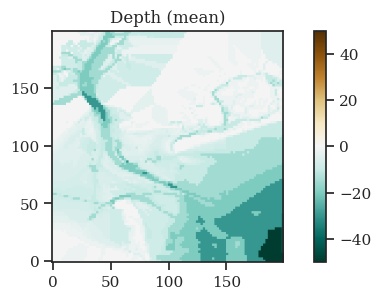

<Figure size 800x300 with 0 Axes>

In [12]:
# We first plot the depth since we have some special handling for it
depth: Depth = star_map.get("depth", "water")
plt.title("Depth (mean)")
depth.plot(value_index=0)
plt.show()
plt.clf()

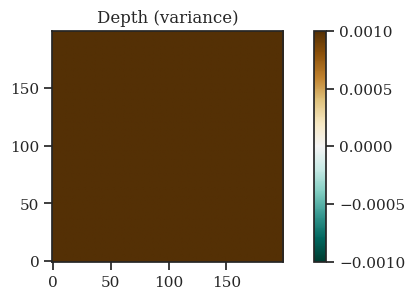

<Figure size 800x300 with 0 Axes>

In [13]:
plt.title("Depth (variance)")
depth.plot(value_index=1)
plt.show()
plt.clf()

In [14]:
all_relations = star_map.relation_and_location_types
all_relations

{'over': {'anchorage', 'land'},
 'distance': {'land', 'water_route'},
 'depth': {'water'}}

Lowered zoom level to keep map size reasonable. (z = 11)
Lowered zoom level to keep map size reasonable. (z = 11)
Lowered zoom level to keep map size reasonable. (z = 11)
Lowered zoom level to keep map size reasonable. (z = 11)
Lowered zoom level to keep map size reasonable. (z = 11)


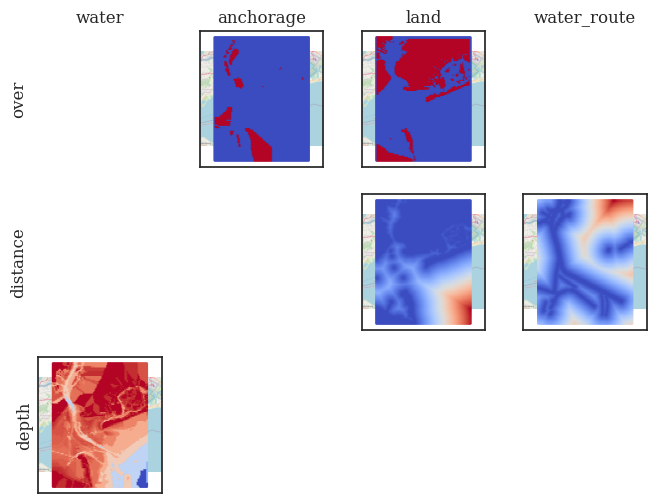

<Figure size 800x300 with 0 Axes>

In [15]:
# Create one row per relation type and one column per location type
fig, axes = plt.subplots(
    len(all_relations), len(star_map.location_types), figsize=(8, 6), sharex=True, sharey=True
)

for i, (relation_type, location_types) in enumerate(all_relations.items()):
    for j, location_type in enumerate(star_map.location_types):
        # Get the axis for the current row and column
        ax = axes[i, j]

        # Label the rows and columns
        if j == 0:
            ax.set_ylabel(relation_type)
        if i == 0:
            ax.set_title(location_type)

        # Get the relation and visualize it
        if location_type in location_types:
            relation = star_map.get(relation_type, location_type)
            relation.parameters.scatter(ax=ax, cmap="coolwarm", s=0.1)
        else:
            # No data available, but we still want to show the label
            ax.set_xticks([])
            ax.set_yticks([])
            # Despine
            sns.despine(ax=ax, left=True, bottom=True, right=True, top=True)

        # if j == len(all_location_types) - 1:
        #     plt.colorbar()

plt.show()
plt.clf()

Lowered zoom level to keep map size reasonable. (z = 11)


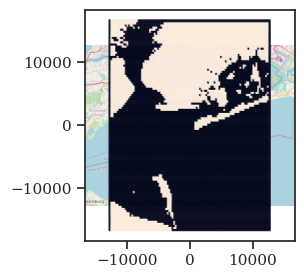

<Figure size 800x300 with 0 Axes>

In [16]:
relation = star_map.get("over", "land")
relation.parameters.scatter(vmin=0, s=0.1)
plt.show()
plt.clf()

In [23]:
folder = output_folder / "relations"
folder.mkdir(exist_ok=True)

for relation_type, location_types in star_map.relation_and_location_types.items():
    for location_type in location_types:
        relation = star_map.get(relation_type, location_type)
        path = folder / f"{relation_type}_{location_type}.csv"
        relation.parameters.to_polar().data.to_csv(path, index=False)

### Run some inference

To make sure everything will run smoothly, we can run some inference on the data.

In [25]:
# In ProMis, we define the constraints of the mission
# as hybrid probabilistic first-order logic programs

# Solve mission constraints using StaRMap parameters and multiprocessing
promis = ProMis(star_map)


% Make sure to only use realtions that are already computed in the StaR Map
landscape(X) :- distance(X, water_route) < 500, depth(X, water) < -5.

depth(x_0, water) ~ normal(0.0, 0.001).
distance(x_0, water_route) ~ normal(3814.272708528796, 0.001).
query(landscape(x_0)).
depth(x_1, water) ~ normal(0.0, 0.001).
distance(x_1, water_route) ~ normal(3723.709191364627, 0.001).
query(landscape(x_1)).
depth(x_2, water) ~ normal(0.0, 0.001).
distance(x_2, water_route) ~ normal(3647.3729634945253, 0.001).
query(landscape(x_2)).

Lowered zoom level to keep map size reasonable. (z = 11)


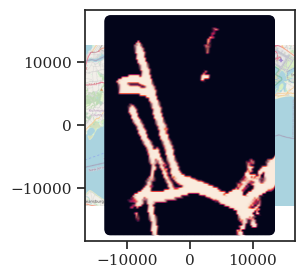

<Figure size 800x300 with 0 Axes>

In [26]:
# Solve an example logic program
logic = r"""
% Make sure to only use realtions that are already computed in the StaR Map
landscape(X) :- distance(X, water_route) < 500, depth(X, water) < -5.
"""
landscape = promis.solve(support, logic, n_jobs=16, batch_size=3, print_first=True)

# Show the resulting landscape
landscape.scatter()
plt.show()
plt.clf()

del landscape  # Make sure this is not used accidentally

## Load some AIS data

The Automatic Identification System (AIS) is a system used for tracking ships. We will use its observations as our measurements and for model validation.

In [27]:
vessel_types = json.loads((Path("..") / "data" / "vessel_types_simplified.json").read_text())
# vessel_types

In [28]:
def load_ais(
    path: str | Path, bbox: None | tuple[tuple[float, float], tuple[float, float]]
) -> pd.DataFrame:
    # Read the csv into pandas
    df = pd.read_csv(path)

    # Filter by bounding box
    if bbox is not None:
        # This is a overly simplistic bounding box filter that only works on moderate latitudes
        # and far from the dateline
        df = df[
            (df["LAT"] > bbox[0][0])
            & (df["LAT"] < bbox[1][0])
            & (df["LON"] > bbox[0][1])
            & (df["LON"] < bbox[1][1])
        ]

    # Sort by time per ship
    df["BaseDateTime"] = pd.to_datetime(df["BaseDateTime"])
    df.sort_values(["MMSI", "BaseDateTime"], inplace=True)

    df.loc[df["VesselType"].isna(), "VesselType"] = 0  # Zero means unknown

    df["VesselType"] = df["VesselType"].astype(int)
    df["VesselTypeName"] = df["VesselType"].astype(str).map(vessel_types)

    # Filter out all vessels that have an average SOG of less than 1 knot
    df = df.groupby("MMSI").filter(lambda x: x["SOG"].mean() > 1)

    return df


df = load_ais(Path("..") / "data" / "ais" / "AIS_2023_08_01.csv", bbox=bbox)
df

,MMSI,BaseDateTime,LAT,LON,SOG,COG,Heading,VesselName,IMO,CallSign,VesselType,Status,Length,Width,Draft,Cargo,TransceiverClass,VesselTypeName
6356009,232040168,2023-08-01 18:14:16,40.41563,-74.02070,102.3,71.0,106.0,DANCING BEAR,IMO0000000,MKTD4,37,NaN,0.0,0.0,NaN,NaN,B,Pleasure craft
6390267,232040168,2023-08-01 18:22:00,40.41702,-74.01857,5.5,31.8,41.0,DANCING BEAR,IMO0000000,MKTD4,37,NaN,0.0,0.0,NaN,NaN,B,Pleasure craft
6391376,232040168,2023-08-01 18:24:03,40.42008,-74.01790,7.9,349.8,2.0,DANCING BEAR,IMO0000000,MKTD4,37,NaN,0.0,0.0,NaN,NaN,B,Pleasure craft
6418027,232040168,2023-08-01 18:27:35,40.42827,-74.01943,9.5,352.2,358.0,DANCING BEAR,IMO0000000,MKTD4,37,NaN,0.0,0.0,NaN,NaN,B,Pleasure craft
6419256,232040168,2023-08-01 18:28:39,40.43095,-74.02005,9.5,353.6,358.0,DANCING BEAR,IMO0000000,MKTD4,37,NaN,0.0,0.0,NaN,NaN,B,Pleasure craft
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2147846,636092711,2023-08-01 06:25:17,40.42155,-73.81043,12.9,188.2,189.0,SEATRADE RED,IMO9690107,D5LR9,70,0.0,185.0,NaN,NaN,79.0,A,Cargo
2153611,636092711,2023-08-01 06:26:28,40.41710,-73.81103,13.9,184.8,186.0,SEATRADE RED,IMO9690107,D5LR9,70,0.0,185.0,NaN,NaN,79.0,A,Cargo
2181613,636092711,2023-08-01 06:27:31,40.41290,-73.81142,14.6,183.5,185.0,SEATRADE RED,IMO9690107,D5LR9,70,0.0,185.0,NaN,NaN,79.0,A,Cargo
2158175,636092711,2023-08-01 06:28:37,40.40835,-73.81178,15.1,183.7,185.0,SEATRADE RED,IMO9690107,D5LR9,70,0.0,185.0,NaN,NaN,79.0,A,Cargo


In [29]:
collection = PolarCollection(origin=origin, number_of_values=0)
collection.append_with_default(df[["LON", "LAT"]].values, value=())
cartesian = collection.to_cartesian()

df.loc[:, "East"] = cartesian.data["east"].values
df.loc[:, "North"] = cartesian.data["north"].values
df

,MMSI,BaseDateTime,LAT,LON,SOG,COG,Heading,VesselName,IMO,CallSign,VesselType,Status,Length,Width,Draft,Cargo,TransceiverClass,VesselTypeName,East,North
6356009,232040168,2023-08-01 18:14:16,40.41563,-74.02070,102.3,71.0,106.0,DANCING BEAR,IMO0000000,MKTD4,37,NaN,0.0,0.0,NaN,NaN,B,Pleasure craft,-6000.582615,-14918.571967
6390267,232040168,2023-08-01 18:22:00,40.41702,-74.01857,5.5,31.8,41.0,DANCING BEAR,IMO0000000,MKTD4,37,NaN,0.0,0.0,NaN,NaN,B,Pleasure craft,-5819.681496,-14764.365122
6391376,232040168,2023-08-01 18:24:03,40.42008,-74.01790,7.9,349.8,2.0,DANCING BEAR,IMO0000000,MKTD4,37,NaN,0.0,0.0,NaN,NaN,B,Pleasure craft,-5762.556086,-14424.618369
6418027,232040168,2023-08-01 18:27:35,40.42827,-74.01943,9.5,352.2,358.0,DANCING BEAR,IMO0000000,MKTD4,37,NaN,0.0,0.0,NaN,NaN,B,Pleasure craft,-5891.689951,-13515.076873
6419256,232040168,2023-08-01 18:28:39,40.43095,-74.02005,9.5,353.6,358.0,DANCING BEAR,IMO0000000,MKTD4,37,NaN,0.0,0.0,NaN,NaN,B,Pleasure craft,-5944.065951,-13217.440337
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2147846,636092711,2023-08-01 06:25:17,40.42155,-73.81043,12.9,188.2,189.0,SEATRADE RED,IMO9690107,D5LR9,70,0.0,185.0,NaN,NaN,79.0,A,Cargo,11844.809203,-14254.245115
2153611,636092711,2023-08-01 06:26:28,40.41710,-73.81103,13.9,184.8,186.0,SEATRADE RED,IMO9690107,D5LR9,70,0.0,185.0,NaN,NaN,79.0,A,Cargo,11794.666422,-14748.465626
2181613,636092711,2023-08-01 06:27:31,40.41290,-73.81142,14.6,183.5,185.0,SEATRADE RED,IMO9690107,D5LR9,70,0.0,185.0,NaN,NaN,79.0,A,Cargo,11762.297638,-15214.896822
2158175,636092711,2023-08-01 06:28:37,40.40835,-73.81178,15.1,183.7,185.0,SEATRADE RED,IMO9690107,D5LR9,70,0.0,185.0,NaN,NaN,79.0,A,Cargo,11732.531930,-15720.188438


### Visualize it

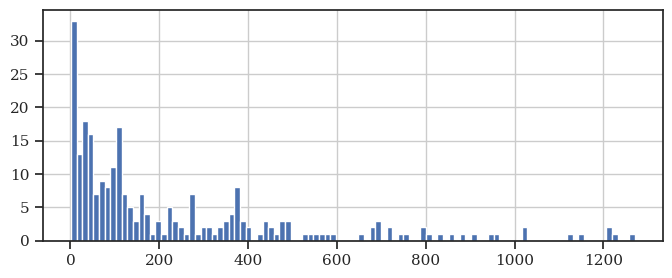

In [30]:
df["MMSI"].value_counts().hist(bins=100)
pass

In [31]:
MMSIs = df["MMSI"].value_counts()
min_observations = 10 + 20 + 15  # warmup + some usage in between + dead_reckoning
relevant_MMSIs = MMSIs[MMSIs > min_observations].index
df = df[df["MMSI"].isin(relevant_MMSIs)]

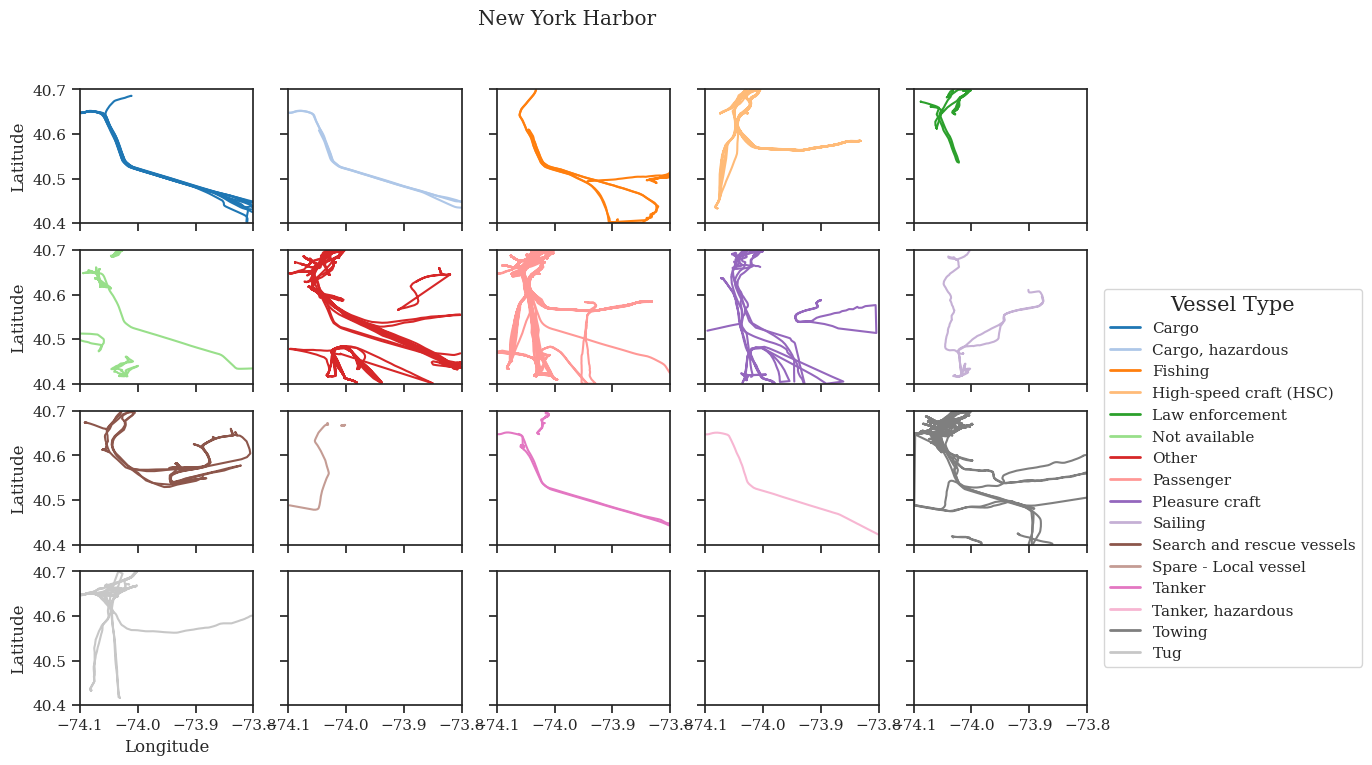

<Figure size 800x300 with 0 Axes>

In [ ]:
vessel_type_to_index = {
    vessel_type: i for i, vessel_type in enumerate(sorted(df["VesselTypeName"].unique()))
}
palette = sns.color_palette("tab20", len(vessel_type_to_index))

relevant_vessel_types = df["VesselTypeName"].unique()

cols = 5
all_rows = ceil(len(relevant_vessel_types) / cols)
fig, ax = plt.subplots(ncols=cols, nrows=all_rows, figsize=(13, 8), sharex=True, sharey=True)

for (vessel_type, i), ax in zip(vessel_type_to_index.items(), ax.flatten()):
    for mmsi in relevant_MMSIs:
        df_ = df[df["MMSI"] == mmsi]
        if relevant_vessel_types is not None and df_["VesselTypeName"].iloc[0] != vessel_type:
            continue
        vessel_type = df_["VesselTypeName"].iloc[0]
        color = palette[vessel_type_to_index[vessel_type]]
        ax.plot(df_["LON"], df_["LAT"], c=color)

    ax.set_xlim(bbox[0][1], bbox[1][1])
    if i >= cols * (all_rows - 1):
        ax.set_xlabel("Longitude")
    ax.set_ylim(bbox[0][0], bbox[1][0])
    if i % cols == 0:
        ax.set_ylabel("Latitude")

    col = i % cols
    row = i // cols
    # if we are in the center, right-hand side
    if col == cols - 1 and row == len(relevant_vessel_types) // cols - 1:
        ax.legend(
            [
                plt.Line2D([0], [0], color=palette[i], lw=2, label=vessel_type)
                for i, vessel_type in enumerate(vessel_type_to_index)
            ],
            vessel_type_to_index.keys(),
            title="Vessel Type",
            loc="center left",
            bbox_to_anchor=(1.05, 0.5),
        )

plt.suptitle(setting)

plt.savefig(output_folder / "ais-all-tracks.pdf", bbox_inches="tight")

plt.show()
plt.clf()

In [33]:
relevant_vessel_types = [
    "Cargo",
    "Cargo hazardous",
    "Search and rescue vessels",
    "Towing",
    "Other",
    "Tanker",
    "Tanker hazardous",
]

In [ ]:
for mmsi in relevant_MMSIs:
    df_ = df[df["MMSI"] == mmsi]
    if df_["VesselTypeName"].iloc[0] not in relevant_vessel_types:
        continue

    plt.plot(df_["LON"], df_["LAT"], c=color)
    plt.xlim(bbox[0][1], bbox[1][1])
    plt.ylim(bbox[0][0], bbox[1][0])
    plt.gca().set_aspect("equal")

    path = output_folder / "plot-individual-traces" / df_["VesselTypeName"].iloc[0]
    path.mkdir(exist_ok=True, parents=True)
    plt.savefig(path / f"{mmsi}.pdf", bbox_inches="tight")
    plt.clf()

<Figure size 800x300 with 0 Axes>

In [35]:
# An example of a single vessel
track_mmsi = 636017103
track_mmsi

636017103

In [36]:
df_ = df[df["MMSI"] == track_mmsi]
df_

,MMSI,BaseDateTime,LAT,LON,SOG,COG,Heading,VesselName,IMO,CallSign,VesselType,Status,Length,Width,Draft,Cargo,TransceiverClass,VesselTypeName,East,North
3960115,636017103,2023-08-01 11:49:35,40.44721,-73.80007,6.3,267.2,270.0,MAERSK SKARSTIND,IMO9740457,D5JH7,70,0.0,300.0,NaN,NaN,71.0,A,Cargo,12719.189958,-11403.440125
4007616,636017103,2023-08-01 11:50:44,40.44706,-73.80274,6.3,267.0,270.0,MAERSK SKARSTIND,IMO9740457,D5JH7,70,0.0,300.0,NaN,NaN,71.0,A,Cargo,12492.710366,-11420.477721
3975932,636017103,2023-08-01 11:51:55,40.44698,-73.80548,6.3,267.8,270.0,MAERSK SKARSTIND,IMO9740457,D5JH7,70,0.0,300.0,NaN,NaN,71.0,A,Cargo,12260.278629,-11429.745157
8645385,636017103,2023-08-01 11:53:06,40.44686,-73.80823,6.3,267.9,270.0,MAERSK SKARSTIND,IMO9740457,D5JH7,70,0.0,300.0,NaN,NaN,71.0,A,Cargo,12027.005130,-11443.448475
3989953,636017103,2023-08-01 11:54:15,40.44682,-73.81085,6.1,269.9,276.0,MAERSK SKARSTIND,IMO9740457,D5JH7,70,0.0,300.0,NaN,NaN,71.0,A,Cargo,11804.745333,-11448.243697
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4648379,636017103,2023-08-01 13:40:39,40.64977,-74.08801,5.8,246.1,245.0,MAERSK SKARSTIND,IMO9740457,D5JH7,70,0.0,300.0,NaN,NaN,71.0,A,Cargo,-11672.743889,11088.235617
4630139,636017103,2023-08-01 13:41:48,40.64906,-74.09025,5.8,247.6,246.0,MAERSK SKARSTIND,IMO9740457,D5JH7,70,0.0,300.0,NaN,NaN,71.0,A,Cargo,-11862.326566,11009.691808
4657127,636017103,2023-08-01 13:42:58,40.64832,-74.09258,5.9,247.5,247.0,MAERSK SKARSTIND,IMO9740457,D5JH7,70,0.0,300.0,NaN,NaN,71.0,A,Cargo,-12059.530932,10927.833752
4646210,636017103,2023-08-01 13:44:09,40.64769,-74.09501,6.0,256.7,259.0,MAERSK SKARSTIND,IMO9740457,D5JH7,70,0.0,300.0,NaN,NaN,71.0,A,Cargo,-12265.177691,10858.210053


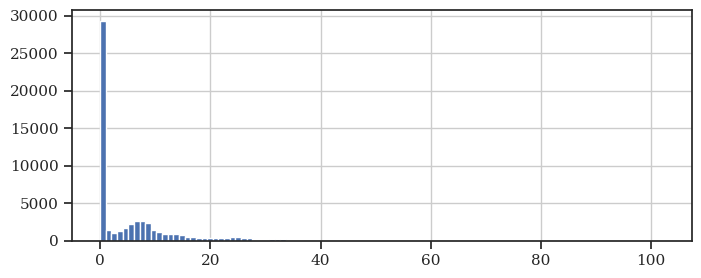

In [37]:
df["SOG"].hist(bins=100)
pass

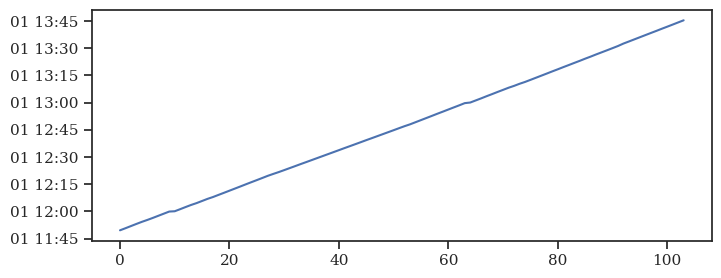

In [38]:
plt.plot(np.arange(len(df_["BaseDateTime"])), df_["BaseDateTime"])
pass

## Compute the ProMis landscapes for the ship categories

In [39]:
def landscape_for_mmsi(mmsi: int) -> CartesianCollection:
    metadata = df[df["MMSI"] == mmsi].iloc[0]

    specific = copy(logic)

    vessel_type = metadata["VesselTypeName"].replace(" ", "_").lower()
    specific += f"\nis_{vessel_type}."
    for vessel_type in relevant_vessel_types:
        if vessel_type != metadata["VesselTypeName"]:
            specific += f"\n0::is_{vessel_type.replace(' ', '_').lower()}."

    length = metadata["Length"]
    if isfinite(length) and length > 0:
        specific += f"\nlength ~ normal({length}, {length * 0.05})."
    else:
        # Some prior knowledge
        specific += "\nlength ~ normal(30, 10)."

    draft = metadata["Draft"]
    if isfinite(length) and draft > 0:
        specific += f"\ncurrent_draft ~ normal({draft}, {draft * 0.1})."
    else:
        # Some prior knowledge
        specific += "\ncurrent_draft ~ normal(2, 1)."

    # This is an example of a time varying feature
    # speed_over_ground = metadata["SOG"]
    # if isfinite(speed_over_ground):
    #     specific += f"\nspeed_over_ground ~ normal({speed_over_ground}, {speed_over_ground*0.1})."
    # else:
    #     # Some prior knowledge
    #     specific += "\nspeed_over_ground ~ normal(5, 5)."

    specific += "\n\n"  # Add newlines for better readability

    promis = ProMis(star_map)
    return promis.solve(support, specific, n_jobs=16, show_progress=False)


landscapes = {
    "Cargo": landscape_for_mmsi(636017103),
    "Search and rescue vessels": landscape_for_mmsi(367531710),
    "Towing": landscape_for_mmsi(303461000),
}

### Save them for external use

In [ ]:
for vessel_type, landscape in landscapes.items():
    # Store the landscape
    polar_collection = landscape.to_polar()
    path = output_folder / "landscape"
    path.mkdir(exist_ok=True)
    polar_collection.data.to_csv(path / f"{vessel_type}.csv", index=False)

    # Store the trace of the vessels
    df_ = df[df["VesselTypeName"] == vessel_type]
    path = output_folder / "ais-trace"
    path.mkdir(exist_ok=True)
    df_[["MMSI", "LAT", "LON"]].to_csv(path / f"{vessel_type}.csv", index=False)

### Visualize the landscapes

In [42]:
# This will be used much later
ship_marker = parse_path(svg2paths("ship-icon.svg")[1][0]["d"])
ship_marker.vertices -= ship_marker.vertices.mean(axis=0)
ship_marker = ship_marker.transformed(Affine2D().rotate_deg(180)).transformed(
    Affine2D().scale(-1, 1)
)

Lowered zoom level to keep map size reasonable. (z = 11)


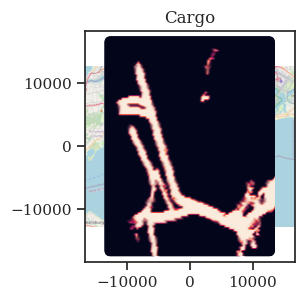

Lowered zoom level to keep map size reasonable. (z = 11)


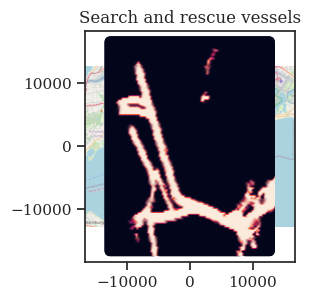

Lowered zoom level to keep map size reasonable. (z = 11)


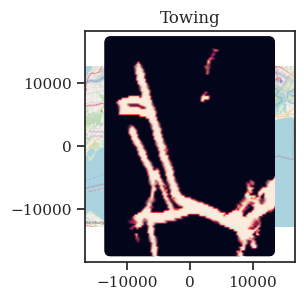

<Figure size 800x300 with 0 Axes>

In [43]:
for name, landscape in landscapes.items():
    landscape.scatter()
    plt.title(name)
    plt.show()
    plt.clf()

In [44]:
interpolators = {
    vessel_type: landscape.get_interpolator(method="nearest")
    for vessel_type, landscape in landscapes.items()
}

In [45]:
typical_ship_speed = 5  # meters per second
typical_sample_time = 60  # seconds

In [46]:
def plot_trajectories(all_positions: ndarray, label: str | None = "Trajectory {}", **kwargs):
    if len(all_positions.shape) == 2:
        all_positions = all_positions[None, ...]
    for i, positions in enumerate(all_positions):
        plt.plot(*zip(*positions), label=label.format(i) if label else None, **kwargs)

Lowered zoom level to keep map size reasonable. (z = 11)


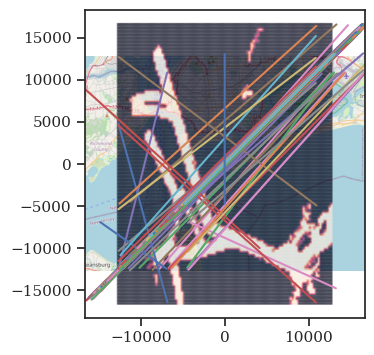

<Figure size 800x300 with 0 Axes>

In [47]:
plt.figure(figsize=(6, 4))
landscape.scatter(s=0.2, alpha=0.5)
positions = stack((df_["East"], df_["North"]))
plot_trajectories(positions, label="True trajectory")
plt.show()
plt.clf()
pass

In [48]:
def plot_trajectories_animated(positions: ndarray, filename: str = "trajectory.gif") -> None:
    fig, _ = plt.subplots()
    landscape.scatter()
    (line,) = plt.plot(*zip(*positions.T), label="Ship Position")

    def update(num, x, y, line):
        line.set_data(x[:num], y[:num])
        line.axes.axis([-width / 2, width / 2, -height / 2, height / 2])
        return (line,)

    ani = FuncAnimation(
        fig,
        update,
        len(positions),
        fargs=[positions[:, 0], positions[:, 1], line],
        interval=1000 / 60,
        blit=True,
    )
    ani.save(filename)
    plt.clf()


# plot_trajectories_animated(positions)

## Old particle filter code

In [ ]:
def run_experiment(
    data: pd.DataFrame,
    dead_reckoning_steps: int = 15,
    verbose: bool = False,
    seed_value: int = 2024,
    eval_skip_warmup: int = 10,
    with_constitution: bool = True,
    constitutional_trust: float = 0.8,
) -> dict:
    seed(seed_value)

    # We define the first and second derivatives in polar coordinates
    # since that is how the AIS data is given (for boat speed and direction)
    # and is is quite natural for the problem at hand (ships change direction
    # more often than speed)
    # column_names = ["x", "y", "dphi", "dr"]  # , "ddphi", "ddr"]
    column_names = ["x", "y", "dx", "dy"]  # , "ddphi", "ddr"]

    # prior sampling function for each variable
    prior_fn = independent_sample(
        [
            uniform(loc=-width / 2, scale=width).rvs,
            uniform(loc=-height / 2, scale=height).rvs,
            # uniform(loc=0, scale=2 * pi).rvs,
            # norm(loc=typical_ship_speed, scale=typical_ship_speed).rvs,
            norm(loc=0, scale=typical_ship_speed).rvs,
            norm(loc=0, scale=typical_ship_speed).rvs,
            # norm(loc=0, scale=0.01 * 2 * pi).rvs,
            # norm(loc=0, scale=0.01 * typical_ship_speed).rvs,
        ]
    )

    def polar_to_cartesian(phi: ndarray, r: ndarray) -> ndarray:
        """Convert polar coordinates to cartesian."""
        return stack((r * np.sin(phi), r * np.cos(phi)), axis=1)

    dt = None

    def state_forward_model(x: ndarray) -> ndarray:
        """Very simple linear dynamics: pos += dpos and dpos += ddpos."""
        nonlocal dt

        xp = np.array(x)

        # However, we need to convert the polar coordinates to cartesian
        # dxy = polar_to_cartesian(xp[:, 2], xp[:, 3])
        # xp[:, 0] += dxy[:, 0] * dt
        # xp[:, 1] += dxy[:, 1] * dt

        xp[:, [0, 1]] += xp[:, [2, 3]] * dt

        # xp[:, 2] %= 2 * pi
        # xp[:, 3] = clip(xp[:, 3], 0, None)

        # First and second derivatives are both in polar coordinates
        # xp[:, [2, 3]] += xp[:, [4, 5]] * dt

        return xp

    trace_weight_e1 = []
    trace_weight_e2 = []

    def weight_fn(hyp, obs) -> ndarray:
        nonlocal trace_weight_e1, trace_weight_e2, with_constitution, constitutional_trust

        # Make sure everything is in cartesian coordinates for proper distance computation
        # Also make sure that the rough scales are the same
        # hyp = hyp.copy()
        # hyp[:, [2, 3]] = polar_to_cartesian(hyp[:, 2], hyp[:, 3])
        # hyp[:, 2] /= typical_ship_speed
        # hyp[:, 3] /= typical_ship_speed
        # obs = obs.copy()
        # obs[:, [2, 3]] = polar_to_cartesian(obs[:, 2], obs[:, 3])
        # obs[:, 2] /= typical_ship_speed
        # obs[:, 3] /= typical_ship_speed

        # Compute by distance to observations
        # speed = obs[0, 3]
        # from numpy import clip
        # speed = clip(speed, 0.5, 10)
        # e1 = squared_error(hyp[:, :2], obs[:, :2], sigma=typical_sample_time * speed * 0.5)
        # e2 = squared_error(hyp[:, 2:], obs[:, 2:], sigma=speed * 0.2)
        # weight = e1 * e2

        weight = squared_error(hyp[:, :2], obs[:, :2], sigma=5)

        trace_weight_e1.append(-1)
        trace_weight_e2.append(-1)

        if with_constitution:
            # constitution = solve_at(promis, hyp[:, :2]).data["v0"].to_numpy()
            constitution = interpolator(hyp[:, :2])[:, 0]

            # plt.hist(from_landscape)
            # plt.xlabel("Landscape Value")
            # plt.ylabel("Frequency")
            # plt.show()
            # plt.clf()

            weight *= constitutional_trust * constitution + (1 - constitutional_trust)
        return weight

    # create the filter
    pf = ParticleFilter(
        prior_fn=prior_fn,
        observe_fn=lambda x: x[:, :4],
        n_particles=2000,
        dynamics_fn=state_forward_model,
        noise_fn=lambda x: gaussian_noise(
            x,
            sigmas=[
                5,
                5,
                0.2,
                0.2,
                # typical_ship_speed * typical_sample_time / 0.5,
                # typical_ship_speed * typical_sample_time / 0.5,
                # 0.03 * 2 * pi,
                # typical_ship_speed * 0.05,
                # typical_ship_speed * 0.5,
                # typical_ship_speed * 0.5,
                # 0.02**2 * 2 * pi,
                # typical_ship_speed * 0.05**2,
            ],
        ),
        weight_fn=weight_fn,
        resample_proportion=0.01,
        n_eff_threshold=0.5,
        column_names=column_names,
    )

    trace_time = []
    trace_all_particles = [pf.particles.copy()]  # only here we already have the initial particles
    trace_state = []
    trace_map_state = []
    trace_hypotheses = []
    trace_map_hypotheses = []
    trace_weights = []
    trace_weights_unnormalized = []

    data.loc[:, "RelativeTime"] = (
        data["BaseDateTime"] - data["BaseDateTime"].iloc[0]
    ).dt.total_seconds()
    assert data["RelativeTime"].is_monotonic_increasing

    ground_truth = stack((data["East"], data["North"], deg2rad(data["COG"]), data["SOG"])).T
    ground_truth[:, [2, 3]] = polar_to_cartesian(ground_truth[:, 2], ground_truth[:, 3])
    deviate_from = len(ground_truth) - dead_reckoning_steps

    for i, obs in enumerate(ground_truth):
        if i == 0:
            dt = 0
        else:
            dt = data["RelativeTime"].iloc[i] - data["RelativeTime"].iloc[i - 1]
        trace_time.append(data["RelativeTime"].iloc[i])

        if i < deviate_from:
            pf.update(obs)
        else:
            pf.update(None)

        if verbose and i % 10 == 0:
            print(f"Step {i + 1}/{len(ground_truth)}")

        trace_all_particles.append(pf.particles.copy())
        trace_state.append(pf.mean_state)
        trace_map_state.append(pf.map_state)
        trace_hypotheses.append(pf.mean_hypothesis)
        trace_map_hypotheses.append(pf.map_hypothesis)
        trace_weights.append(pf.weights)
        trace_weights_unnormalized.append(pf.weights_unnormalized)

    trace_all_particles = array(trace_all_particles)
    trace_state = array(trace_state)
    trace_map_state = array(trace_map_state)
    trace_hypotheses = array(trace_hypotheses)
    trace_map_hypotheses = array(trace_map_hypotheses)
    trace_weights = array(trace_weights)
    trace_weights_unnormalized = array(trace_weights_unnormalized)
    trace_weight_e1 = array(trace_weight_e1)
    trace_weight_e2 = array(trace_weight_e2)

    # Evaluate the filter
    position_accuracy_mean = np.linalg.norm(trace_state[:, :2] - ground_truth[:, :2], axis=1)[
        eval_skip_warmup:
    ]
    position_accuracy_map = np.linalg.norm(trace_map_state[:, :2] - ground_truth[:, :2], axis=1)[
        eval_skip_warmup:
    ]

    return {
        "ground_truth": ground_truth,
        "trace_time": trace_time,
        "deviate_from": deviate_from,
        "trace_all_particles": trace_all_particles,
        "trace_state": trace_state,
        "trace_map_state": trace_map_state,
        "trace_hypotheses": trace_hypotheses,
        "trace_map_hypotheses": trace_map_hypotheses,
        "trace_weights": trace_weights,
        "trace_weights_unnormalized": trace_weights_unnormalized,
        "trace_weight_e1": trace_weight_e1,
        "trace_weight_e2": trace_weight_e2,
        "particle_filter": pf,
        "position_accuracy_mean": position_accuracy_mean,
        "position_accuracy_map": position_accuracy_map,
    }


debug_df = df[df["MMSI"] == relevant_MMSIs[6]].copy()
# result = run_experiment(debug_df.iloc[:200], constitutional_trust=0)

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
for i, ax in enumerate(axes.flatten()):
    if i >= result["trace_all_particles"].shape[2]:
        break
    ax.plot(result["trace_all_particles"][:, :, i], alpha=0.2)
    ax.plot(result["trace_state"][:, i], c="black", lw=2, label="Mean")
    ax.plot(result["trace_map_state"][:, i], c="red", lw=2, label="MAP")
    if i < result["ground_truth"].shape[1]:
        ax.plot(result["ground_truth"][:, i], c="green", lw=2, label="Ground Truth")
    ax.set_title(result["particle_filter"].column_names[i])

    # ax.axvline(result["deviate_from"], c="black", ls="--", lw=1)

    if i == 0:
        ax.set_ylim(-width, width)
    if i == 1:
        ax.set_ylim(-height, height)

    if i == 0:
        ax.legend()

axes[1, 0].axhline(2 * pi, c="black", ls="--", lw=1)

plt.tight_layout()
plt.show()
plt.clf()

## Particle filtering on our own

In [ ]:
def run_experiment_pf1(
    data: ndarray,
    seed_value: int = 2024,
    constitutional_trust: float = 0.8,
    interpolator=None,
    full_inference: bool = False,
    use_constitution: bool = True,
) -> pd.DataFrame:
    def create_initial_particles(N: int) -> ndarray:
        return np.stack(
            [
                uniform(loc=-width / 2, scale=width).rvs(N),
                uniform(loc=-height / 2, scale=height).rvs(N),
                uniform(loc=0, scale=2 * pi).rvs(N),
                norm(loc=5, scale=3).rvs(N),
                # norm(loc=0, scale=typical_ship_speed).rvs(N),
                # norm(loc=0, scale=typical_ship_speed).rvs(N),
            ]
        ).T

    def predict(particles, dt=1.0):
        """move according to control input u (heading change, velocity)
        with noise Q (std heading change, std velocity)`"""

        particles = particles.copy()

        N = len(particles)

        # noise = standard_normal(N) * std[1]
        # particles[:, [0, 1]] += particles[:, [2, 3]] * dt + noise

        particles[:, 2] += standard_normal(N) * 0.05
        particles[:, 2] %= 2 * pi

        particles[:, 3] += standard_normal(N) * 0.3

        dist = particles[:, 3] * dt  # + (standard_normal(N) * std)

        # TODO: possibly also add noise to the heading
        particles[:, 0] += np.cos(particles[:, 2]) * dist
        particles[:, 1] += np.sin(particles[:, 2]) * dist

        return particles

    def update(
        particles,
        weights,
        z,
        R,
        use_constitution: bool = use_constitution,
        constitutional_trust: float = constitutional_trust,
    ):
        weights = weights.copy()

        positions = particles[:, :2]
        distance = np.linalg.norm(positions - z, axis=1)

        # Evaluate and RBF kernel
        weights *= np.exp(-(distance**2) / (2 * R**2))

        if use_constitution:
            constitution = interpolator(positions)[:, 0]
            weights *= constitutional_trust * constitution + (1 - constitutional_trust)

        weights += 1.0e-300  # avoid round-off to zero
        weights /= sum(weights)  # normalize

        return weights

    def estimate(particles, weights):
        """returns mean and variance of the weighted particles"""

        mean = np.average(particles, weights=weights, axis=0)
        var = np.average((particles - mean) ** 2, weights=weights, axis=0)
        return mean, var

    def neff(weights):
        return 1.0 / np.sum(np.square(weights))

    def resample_from_index(particles, weights, indexes):
        particles[:] = particles[indexes]
        weights.resize(len(particles))
        weights.fill(1.0 / len(weights))

    def run_pf1(
        N,
        data,
        sensor_std_err=5000,
        do_plot=False,
        plot_particles=False,
    ):
        if do_plot:
            plt.figure()

        # create particles
        particles = create_initial_particles(N)
        particles[:, 0] = norm(loc=data[0, 0], scale=1000).rvs(N)
        particles[:, 1] = norm(loc=data[0, 1], scale=1000).rvs(N)

        # create weights
        weights = np.ones(N) / N

        if do_plot and plot_particles:
            alpha = 0.20
            if N > 5000:
                alpha *= np.sqrt(5000) / np.sqrt(N)
            plt.scatter(particles[:, 0], particles[:, 1], alpha=alpha, color="g")

        weights_trace = []
        particle_trace = []
        xs = []
        for i, obs in enumerate(data):
            # move
            particles = predict(particles, dt=obs[4])

            # incorporate measurements
            weights = update(particles, weights, z=obs[:2], R=sensor_std_err)

            # resample if too few effective particles
            if neff(weights) < N / 2:
                indexes = systematic_resample(weights)
                resample_from_index(particles, weights, indexes)
                assert np.allclose(weights, 1 / N)
            mu, var = estimate(particles, weights)
            xs.append(mu)

            weights_trace.append(weights.copy())
            particle_trace.append(particles.copy())

            if do_plot:
                if plot_particles:
                    plt.scatter(
                        particles[:, 0], particles[:, 1], color="k", marker=",", s=0.5, alpha=0.2
                    )
                p1 = plt.scatter(obs[0], obs[1], marker="x", color="r")
                p2 = plt.scatter(mu[0], mu[1], marker="s", color="b")

            # print(f"Step {i+1}/{len(data)}")

        xs = np.array(xs)
        # plt.plot(xs[:, 0], xs[:, 1])
        if do_plot:
            plt.legend([p1, p2], ["Actual", "PF"], loc=4, numpoints=1)
        # plt.xlim(-width / 2, width / 2)
        # plt.ylim(-height / 2, height / 2)

        pos_error = np.linalg.norm(mu[:2] - data[:, :2], axis=1)
        # print("error, variance: ", pos_error.mean(), pos_error.var())
        all_error = np.linalg.norm(xs[:, :] - data[:, :4], axis=1)
        # print("all error, variance: ", all_error.mean(), all_error.var())

        if do_plot:
            plt.show()

        return {
            "particles": array(particle_trace),
            "weights": array(weights_trace),
            "estimates": xs,
            "pos_error": pos_error,
            "pos_error_mean": pos_error.mean(),
            "all_error": all_error,
            "all_error_mean": all_error.mean(),
            "truth": data,
        }

    data.loc[:, "RelativeTime"] = (
        data["BaseDateTime"] - data["BaseDateTime"].iloc[0]
    ).dt.total_seconds()
    assert data["RelativeTime"].is_monotonic_increasing

    ground_truth = stack(
        (data["East"], data["North"], deg2rad(data["COG"]), data["SOG"], data["RelativeTime"])
    ).T

    ground_truth[0, 4] = 0
    ground_truth[1:, 4] = ground_truth[1:, 4] - ground_truth[:-1, 4]

    seed(seed_value)
    return run_pf1(N=2000, data=ground_truth, plot_particles=True)


In [ ]:
results = []

# df_for_type = df[df["VesselTypeName"].isin(relevant_vessel_types)]
df_for_type = df[df["VesselTypeName"].isin(landscapes.keys())]
df_for_type = df_for_type[df_for_type["MMSI"].isin(relevant_MMSIs)]

for tau in np.arange(0.0, 1.1, 0.1):
    for mmsi in relevant_MMSIs:
        for seed_value in [2024]:
            data = df_for_type[df_for_type["MMSI"] == mmsi].copy()
            if data.empty:
                continue
            vessel_type = data["VesselTypeName"].iloc[0]

            interpolator = interpolators[vessel_type]
            experiment_result = run_experiment_pf1(
                data,
                constitutional_trust=tau,
                seed_value=seed_value,
                interpolator=interpolator,
            )
            results.append(
                dict(
                    mmsi=mmsi,
                    type=vessel_type,
                    tau=tau,
                    seed=seed_value,
                    **experiment_result,
                )
            )
            print(
                f"Finished {mmsi} (progress: {len(results)}/{len(df_for_type['MMSI'].unique()) * 11})"
            )

df_results = pd.DataFrame(results)
df_results

In [ ]:
len(data)

In [ ]:
# before = monotonic()
# run_experiment_pf1(
#     data[:20],
#     constitutional_trust=0.5,
#     seed_value=2024,
#     interpolator=interpolator,
#     full_inference=False,
#     use_constitution=True,
# )
# after = monotonic()
# after - before

In [ ]:
df_results.to_pickle("res-all-taus.pkl")

In [ ]:
df_results = pd.read_pickle("res-all-taus-paper.pkl")

In [ ]:
df_results["type"].unique()

In [ ]:
df_results

In [ ]:
df_results[df_results["tau"] != 0.0]["pos_error_mean"]

In [ ]:
# with_benefit = df_results.groupby("mmsi").apply(
#     lambda group: group.assign(
#         benefit=(
#             group[group["tau"] != 0.0]["pos_error_mean"].min()
#             - group[group["tau"] == 0.0]["pos_error_mean"].item()
#         )
#     ),
#     include_groups=False,
# )

In [ ]:
with_benefit = df_results.groupby("mmsi").apply(
    lambda group: group.copy()[
        (group["tau"] == 0.0)
        | (group["pos_error_mean"] == group[group["tau"] != 0.0]["pos_error_mean"].min())
    ]
    .assign(
        benefit=(
            group[group["tau"] != 0.0]["pos_error_mean"].min()
            - group[group["tau"] == 0.0]["pos_error_mean"].item()
        )
    )
    .sort_values("tau"),
    include_groups=False,
)

In [ ]:
# with_benefit = with_benefit[
#     (with_benefit["benefit"] > max(with_benefit["benefit"].quantile(0.6).item(), 0))
# ]
with_benefit

In [ ]:
results = with_benefit.loc[[with_benefit.index.get_level_values(0)[::2][10]]]
results

In [ ]:
result_pf, result_cofi = results.iloc[0], results.iloc[1]
result = result_cofi

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10))

columns = ["x", "y", "d_phi", "d_r"]

# time_start = 0
# time_end = 400

for i, ax in enumerate(axes.flatten()):
    if i >= result["particles"].shape[2]:
        break
    ax.plot(result["particles"][:, :, i], alpha=0.2)

    if i < result_pf["estimates"].shape[1]:
        ax.plot(result_pf["estimates"][:, i], c="black", lw=2, label="Mean_plain")
    if i < result_cofi["estimates"].shape[1]:
        ax.plot(result_cofi["estimates"][:, i], c="black", lw=2, label="Mean_const")

    if i < result["truth"].shape[1]:
        ax.plot(result["truth"][:, i], c="green", lw=2, label="Ground Truth")
    ax.set_title(columns[i])

    # ax.axvline(result["deviate_from"], c="black", ls="--", lw=1)

    if i == 0:
        ax.set_ylim(-width, width)
    if i == 1:
        ax.set_ylim(-height, height)

    if i == 0:
        ax.legend()

axes[1, 0].axhline(2 * pi, c="black", ls="--", lw=1)

plt.tight_layout()
plt.show()
plt.clf()

In [ ]:
plt.figure(figsize=(6, 4))
landscape.scatter(s=2, alpha=0.5)
plot_trajectories(result_pf["truth"][:, :2], label="True trajectory")
plot_trajectories(result_pf["estimates"][:, :2], label="Estimated trajectory (PF)")
plot_trajectories(result_cofi["estimates"][:, :2], label="Estimated trajectory (CoFi)")

# show_n_particles = 10
# plot_trajectories(trace_all_particles[:, :show_n_particles, :2].swapaxes(1, 0), label=None)

scale = 1.5
# plt.gca().set_xlim(-width / 2 * scale, width / 2 * scale)
# plt.gca().set_ylim(-height / 2 * scale, height / 2 * scale)

# plt.gca().set_xlim(-15_000, -2_000)
# plt.gca().set_ylim(8_000, 18_000)

all_coords = np.concatenate(
    [result_pf["truth"][:, :2], result_pf["estimates"][:, :2], result_cofi["estimates"][:, :2]]
)
plt.gca().set_xlim(all_coords[:, 0].min(), all_coords[:, 0].max())
plt.gca().set_ylim(all_coords[:, 1].min(), all_coords[:, 1].max())

# Move legend to the right of the plot
plt.legend()
move_legend(plt.gca(), loc="center left", bbox_to_anchor=(1.3, 0.5))

plt.colorbar()
pass

In [ ]:
def cartesian_to_polar(coords: ndarray) -> ndarray:
    collection = CartesianCollection(origin=origin, dimensions=1)
    collection.append_with_default(coords, np.nan)
    return collection.to_polar().coordinates()


def make_line_string(cartesian_coords: ndarray) -> str:
    return json.dumps(
        {
            "type": "LineString",
            "coordinates": cartesian_to_polar(cartesian_coords).tolist(),
        }
    )


start_date = "2023-08-01 0:0:00"
date_format = "%Y-%m-%d %X"


def make_route_points(cartesian_coords: ndarray) -> str:
    """

    Args:
        cartesian_coords: Shape (T, 2)
    """
    return json.dumps(
        {
            "type": "FeatureCollection",
            "features": [
                {
                    "type": "Feature",
                    "geometry": {
                        "type": "Point",
                        "coordinates": coord.tolist(),
                    },
                    "properties": {
                        "timestamp": time,
                    },
                }
                for coord, time in zip(
                    cartesian_to_polar(cartesian_coords),
                    pd.date_range(start=start_date, periods=cartesian_coords.shape[0]).strftime(
                        date_format
                    ),
                )
            ],
        }
    )


def make_particles(cartesian_coords: ndarray, weights: ndarray) -> str:
    """

    Args:
        cartesian_coords: Shape (T, N, 2)
        weights: Shape (T, N)
    """
    return json.dumps(
        {
            "type": "FeatureCollection",
            "features": [
                {
                    "type": "Feature",
                    "geometry": {
                        "type": "Point",
                        "coordinates": coord.tolist(),
                    },
                    "properties": {
                        "timestamp": time,
                        "weight": weight,
                    },
                }
                for coords_t, weights_t, time in zip(
                    cartesian_coords,
                    weights,
                    pd.date_range(start=start_date, periods=cartesian_coords.shape[0]).strftime(
                        date_format
                    ),
                )
                for coord, weight in zip(
                    cartesian_to_polar(coords_t),
                    weights_t.tolist(),
                )
            ],
        }
    )

In [ ]:
result_pf

In [ ]:
result_pf["weights"].shape

### Visualize using Kepler.gl

In [ ]:
subsample_particles = 4
map = KeplerGl(
    data={
        "True Trajectory Track": make_line_string(result_pf["truth"][:, :2]),
        "True Trajectory": make_route_points(result_pf["truth"][:, :2]),
        #
        "Estimated Trajectory (CoFi) Track": make_line_string(result_cofi["estimates"][:, :2]),
        "Estimated Trajectory (CoFi)": make_route_points(result_cofi["estimates"][:, :2]),
        #
        "Estimated Trajectory (PF) Track": make_line_string(result_pf["estimates"][:, :2]),
        "Estimated Trajectory (PF)": make_route_points(result_pf["estimates"][:, :2]),
        #
        "Particles (PF)": make_particles(
            result_pf["particles"][:, :subsample_particles, :2],
            weights=result_pf["weights"][:, :subsample_particles],
        ),
        "Particles (CoFi)": make_particles(
            result_cofi["particles"][:, :subsample_particles, :2],
            weights=result_cofi["weights"][:, :subsample_particles],
        ),
    },
    config={
        "version": "v1",
        "config": {
            "mapState": {
                "latitude": cartesian_to_polar(all_coords)[:, 1].mean(),
                "longitude": cartesian_to_polar(all_coords)[:, 0].mean(),
                "zoom": 11,
            },
            "visState": {
                "filters": [
                    {
                        "dataId": [data_field],
                        "id": f"94q7ipgwi-{data_field}",
                        "name": ["timestamp"],
                        "type": "DateTime",
                        "yAxis": None,
                        "speed": 0.2,
                    }
                    for data_field in [
                        "True Trajectory",
                        "Estimated Trajectory (CoFi)",
                        "Estimated Trajectory (PF)",
                        "Particles (PF)",
                        "Particles (CoFi)",
                    ]
                ]
            },
        },
    },
)
map.save_to_html(file_name="debug_keplergl.html")
map

You can now invoke `show-html.py` to serve the HTML file.

### Visualize the results with matplotlib

In [ ]:
res_ = []
for vessel_type in interpolators:
    df_ = df[df["VesselTypeName"] == vessel_type]
    points = df_[["East", "North"]].values
    c = interpolators[vessel_type](points)
    for value in c:
        res_.append(
            {
                "Vessel Type": vessel_type,
                "Constitutional": value.item(),
            }
        )

res_df = pd.DataFrame(res_)
res_df

In [ ]:
sns.barplot(
    data=res_df.replace({"Vessel Type": {"Search and rescue vessels": "SAR"}}),
    x="Vessel Type",
    y="Constitutional",
    hue="Vessel Type",
    order=["Cargo", "Towing", "SAR"],
    hue_order=["Cargo", "Towing", "SAR"],
)
sns.despine()
plt.ylabel(r"Average $P(c_t | \mathbf{x}_t, \mathbf{z}_t)$")
plt.xlabel("")
plt.ylim(0, 1)
plt.savefig(Path(".") / "plots" / f"ais-{setting}-constitution.pdf", bbox_inches="tight")
pass

In [ ]:
df_results.head()

In [ ]:
df_results_export = df_results.copy()[
    ["mmsi", "type", "tau", "seed", "pos_error_mean", "all_error_mean"]
]
df_results_export.to_csv("res-all-taus-export.csv", index=False)

df_ = df_results_export.rename(
    columns={
        "type": "Vessel Type",
        "tau": r"$\tau$",
        "pos_error_mean": "Relative Position Error",
    }
)
df_ = df_[df_["Relative Position Error"] < 100_000]
reference_error = df_[(df_["Vessel Type"] == "Cargo") & (df_[r"$\tau$"] == 0.0)][
    "Relative Position Error"
].mean()
df_["Relative Position Error"] /= reference_error
sns.barplot(
    x=r"$\tau$",
    y="Relative Position Error",
    hue="Vessel Type",
    data=df_[df_[r"$\tau$"].isin([0.0, 0.5, 1.0])],
    hue_order=["Cargo", "Towing", "Search and rescue vessels"],
)

# mvoe the legend outside
sns.move_legend(plt.gca(), "upper left", bbox_to_anchor=(1, 1))

sns.despine()

plt.savefig(Path(".") / "plots" / "relative_position_error.pdf", bbox_inches="tight")
pass

In [ ]:
# sns.barplot(x="tau", y="all_error_mean", hue="type", data=df_results)
sns.boxenplot(
    x="tau",
    y="all_error_mean",
    hue="type",
    data=df_results,
    # width_method="linear",
)
pass

In [ ]:
sns.barplot(x="tau", y="pos_error_mean", hue="type", data=df_results)
plt.ylim(None, 30_000)

In [ ]:
# Groub by MMSI and trhen take the tau with the lowest error each
# df_results[["mmsi", "pos_error_mean"]].groupby("mmsi").apply(
#     lambda x: x.sort_values("tau").loc[x["pos_error_mean"].idxmin()]
# )
res = []
for mmis in df_results["mmsi"].unique():
    df_ = df_results[df_results["mmsi"] == mmis]
    # sort by tau
    df_ = df_.sort_values("pos_error_mean")
    res.append((df_["type"].iloc[0], df_["tau"].iloc[0]))

res = pd.DataFrame(res, columns=["Vessel Type", r"$\tau$"])
# Rname Search and rescue vessels to SAR
res["Vessel Type"] = res["Vessel Type"].replace("Search and rescue vessels", "SAR")
res

In [ ]:
r_ = res.copy()

# r_["Vessel Type"] = "All"
# res_ = pd.concat([res, r_], axis=0)
# res_.sort_values("Vessel Type", inplace=True)

sns.histplot(
    r_,
    x=r"$\tau$",
    hue="Vessel Type",
    multiple="stack",
    bins=10,
    stat="percent",
    shrink=0.75,
    # palette="colorblind",
)

plt.ylabel("")
plt.yticks(plt.yticks()[0], [f"{i.get_text()}%" for i in plt.yticks()[1]])
sns.despine()

# Fix the placmenet of the x-axis
plt.xticks(np.arange(0, 1.1, 0.1) + 0.05, [f"{i:.1f}" for i in np.arange(0, 1.1, 0.1)])

plt.savefig(Path(".") / "plots" / "tau-distribution.pdf", bbox_inches="tight")

pass

In [ ]:
sns.displot(
    df_results,
    x="pos_error_mean",  # or "all_error"
    col="tau",
    col_wrap=3,
    facet_kws=dict(margin_titles=True),
)

## Older stuff

In [ ]:
results = []

df_for_type = df[df["VesselTypeName"].isin(["Cargo", "Cargo hazardous"])]

for tau in [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]:
    for mmsi in relevant_MMSIs:
        for seed_value in [2024]:
            data = df_for_type[df_for_type["MMSI"] == mmsi].copy()
            if data.empty:
                continue
            vessel_type = data["VesselTypeName"].iloc[0]
            experiment_result = run_experiment(
                data, constitutional_trust=tau, seed_value=seed_value, verbose=False
            )
            results.append(
                dict(
                    mmsi=mmsi,
                    type=vessel_type,
                    tau=tau,
                    seed=seed_value,
                    mean_mean=np.mean(experiment_result["position_accuracy_mean"]),
                    mean_std=np.std(experiment_result["position_accuracy_mean"]),
                    map_mean=np.mean(experiment_result["position_accuracy_map"]),
                    map_std=np.std(experiment_result["position_accuracy_map"]),
                    **experiment_result,
                )
            )
            print(f"Finished {mmsi} (progress: {len(results)}/{len(df_for_type['MMSI'].unique())})")

df_results = pd.DataFrame(results)
df_results

In [ ]:
sns.displot(
    df_results,
    x="mean_mean",
    col="tau",
    col_wrap=3,
    facet_kws=dict(margin_titles=True),
)

In [ ]:
g = sns.catplot(
    data=df_results,
    kind="bar",
    x="tau",
    y="mean_mean",
    errorbar="sd",
    alpha=0.6,
    height=6,
)

In [ ]:
# Visualize the weights of the particles
plt.plot(result["trace_weights_unnormalized"])
pass

In [ ]:
plt.plot(np.diff(result["trace_time"]) / 60)
pass

In [ ]:
# plt.hist(trace_all_particles[20, :, 2].ravel(), bins=100)
# pass

In [ ]:
plt.figure(figsize=(6, 4))
landscape.scatter(s=0.1, alpha=0.5)
plot_trajectories(result["ground_truth"], label="True trajectory")
plot_trajectories(result["trace_state"][:, :2], label="Estimated trajectory")

# show_n_particles = 10
# plot_trajectories(trace_all_particles[:, :show_n_particles, :2].swapaxes(1, 0), label=None)

scale = 1.5
plt.gca().set_xlim(-width / 2 * scale, width / 2 * scale)
plt.gca().set_ylim(-height / 2 * scale, height / 2 * scale)

plt.colorbar()
plt.legend()
pass

In [ ]:
plt.figure(figsize=(6, 4))
plt.gca().set_aspect("equal")
landscape.scatter(s=0.1, alpha=0.2)
# plt.scatter(*result["trace_all_particles"][:, :, :2][50, ...].T, c="r", s=1)
plt.scatter(*debug_df[["East", "North"]].values.T, c="r", s=1)
plt.xlim(-width / 2 * scale, width / 2 * scale)
plt.ylim(-height / 2 * scale, height / 2 * scale)

pass

In [ ]:
index = 30

plt.gca().set_aspect("equal")

# draw a box around the observed frame
plt.plot(
    [-width / 2, width / 2, width / 2, -width / 2, -width / 2],
    [-height / 2, -height / 2, height / 2, height / 2, -height / 2],
    "k-",
    alpha=0.3,
    label="Frame",
)

plot_trajectories(result["ground_truth"], label="True trajectory", color="k", alpha=0.3)

plt.hist2d(
    *result["trace_all_particles"][index, :, :2].T,
    bins=50,
    range=[[-width / 2 * scale, width / 2 * scale], [-height / 2 * scale, height / 2 * scale]],
    cmap="Oranges",
)

if index > 0:
    # Plot the ship position and position estimate at that time point
    plt.gca().plot(
        *result["ground_truth"][index - 1],
        marker=ship_marker,
        markersize=14,
        label="True position",
        c="k",
        alpha=0.5,
    )
    plt.gca().plot(
        *result["trace_state"][index - 1, :2],
        marker=ship_marker,
        markersize=14,
        label="Estimated position",
        c="b",
    )


plt.legend(
    loc="center left",
    bbox_to_anchor=(1, 0.5),
)
pass

In [ ]:
res_starmap = pd.DataFrame(
    [
        dict(name=r"StarMap ($100 \times x 100$)", time=640.4149391481187),
        dict(name=r"StarMap ($100 \times x 100$)", time=627.0258562378585),
        dict(name=r"StarMap ($100 \times x 100$)", time=624.6253640819341),
        #
        dict(name=r"StarMap ($50 \times 50$)", time=495.63382973195985),
        dict(name=r"StarMap ($50 \times 50$)", time=487.28305474994704),
        dict(name=r"StarMap ($50 \times 50$)", time=487.8447328049224),
    ]
)
res_perf = pd.DataFrame(
    [
        dict(name="Particle Filter", time=0.03765651909634471 / 20),
        dict(name="Particle Filter", time=0.0383494570851326 / 20),
        dict(name="Particle Filter", time=0.03719700896181166 / 20),
        #
        dict(name="CoFi", time=113.63170561008155 / 20),
        dict(name="CoFi", time=113.54428059794009 / 20),
        dict(name="CoFi", time=113.22225885814987 / 20),
        #
        dict(name="CoFi Precomputed", time=0.051308222813531756 / 20),
        dict(name="CoFi Precomputed", time=0.04675357579253614 / 20),
        dict(name="CoFi Precomputed", time=0.05256968503817916 / 20),
    ]
)
cocktail = pd.DataFrame(
    [
        dict(name=r"StarMap ($100 \times 100$)", time=640.4149391481187),
        dict(name=r"StarMap ($100 \times 100$)", time=627.0258562378585),
        dict(name=r"StarMap ($100 \times 100$)", time=624.6253640819341),
        #
        dict(name=r"StarMap ($50 \times 50$)", time=495.63382973195985),
        dict(name=r"StarMap ($50 \times 50$)", time=487.28305474994704),
        dict(name=r"StarMap ($50 \times 50$)", time=487.8447328049224),
        #
        dict(name="CoFi\n10 iterations", time=113.63170561008155 / 20 * 10),
        dict(name="CoFi\n10 iterations", time=113.54428059794009 / 20 * 10),
        dict(name="CoFi\n10 iterations", time=113.22225885814987 / 20 * 10),
    ]
)
cocktail

In [ ]:
sns.barplot(data=cocktail, x="name", y="time", hue="name", palette="colorblind")
plt.xlabel("")
sns.despine()